In [1]:
print("Hello")

Hello


In [4]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from torch.optim import AdamW
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Simplified dataset with 2 classes (person and car) and 500/100 images
class MiniDataset(Dataset):
    def __init__(self, num_samples=20, transforms=None):
        self.transforms = transforms
        self.classes = ['__background__', 'person', 'car']
        self.num_samples = num_samples

    def __getitem__(self, idx):
        # Create dummy image data (replace with actual images)
        img = np.random.randint(0, 255, (300, 400, 3), dtype=np.uint8)

        # Create 1-3 random boxes per image
        num_boxes = np.random.randint(1, 4)
        boxes = []
        labels = []
        for _ in range(num_boxes):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            x2 = x1 + np.random.randint(50, 150)
            y2 = y1 + np.random.randint(50, 150)
            boxes.append([x1, y1, x2, y2])
            labels.append(np.random.randint(1, 3))  # 1 or 2 (person or car)

        img = Image.fromarray(img)
        target = {'boxes': torch.tensor(boxes), 'labels': torch.tensor(labels)}

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return self.num_samples

# Simple transform
def get_transform():
    return torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])


Using device: cuda


Train dataset size: 500
Test dataset size: 100


Epoch 1/10: 100%|██████████| 125/125 [02:00<00:00,  1.03it/s, loss=8.75]


Epoch 1 loss: 12.2538


Epoch 2/10: 100%|██████████| 125/125 [02:01<00:00,  1.03it/s, loss=10.5]


Epoch 2 loss: 9.1179


Epoch 3/10: 100%|██████████| 125/125 [02:01<00:00,  1.03it/s, loss=7.88]


Epoch 3 loss: 8.8120


Epoch 4/10: 100%|██████████| 125/125 [02:01<00:00,  1.03it/s, loss=11.9]


Epoch 4 loss: 8.7808


Epoch 5/10: 100%|██████████| 125/125 [02:01<00:00,  1.03it/s, loss=5.84]


Epoch 5 loss: 8.9965


Epoch 6/10: 100%|██████████| 125/125 [02:01<00:00,  1.03it/s, loss=9.2]


Epoch 6 loss: 8.5747


Epoch 7/10: 100%|██████████| 125/125 [02:01<00:00,  1.03it/s, loss=7.76]


Epoch 7 loss: 8.7362


Epoch 8/10: 100%|██████████| 125/125 [02:01<00:00,  1.03it/s, loss=7.22]


Epoch 8 loss: 8.4113


Epoch 9/10: 100%|██████████| 125/125 [02:01<00:00,  1.03it/s, loss=13.8]


Epoch 9 loss: 8.7605


Epoch 10/10: 100%|██████████| 125/125 [02:01<00:00,  1.03it/s, loss=7.62]


Epoch 10 loss: 8.6657


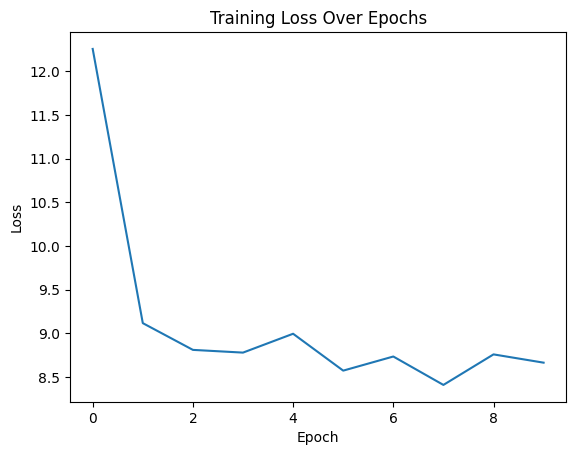

In [5]:

# Create datasets (500 train, 100 test)
dataset_train = MiniDataset(num_samples=500, transforms=get_transform())
dataset_test = MiniDataset(num_samples=100, transforms=get_transform())

print(f"Train dataset size: {len(dataset_train)}")
print(f"Test dataset size: {len(dataset_test)}")

# Create data loaders
data_loader_train = DataLoader(
    dataset_train, batch_size=4, shuffle=True,  # Increased batch size from 2 to 4
    collate_fn=lambda x: tuple(zip(*x)))

data_loader_test = DataLoader(
    dataset_test, batch_size=2, shuffle=False,  # Increased batch size from 1 to 2
    collate_fn=lambda x: tuple(zip(*x)))

# Load Swin Transformer backbone with proper feature extraction
from torchvision.models import swin_t
backbone = swin_t(weights='DEFAULT')

# Extract features from Swin
class SwinBackbone(torch.nn.Module):
    def __init__(self, swin_model):
        super().__init__()
        self.features = torch.nn.Sequential(
            swin_model.features,
            swin_model.norm,
            swin_model.permute,
            swin_model.avgpool,
            swin_model.flatten
        )
        self.out_channels = 768  # Must define this for FasterRCNN

    def forward(self, x):
        return {'0': self.features(x).unsqueeze(-1).unsqueeze(-1)}  # Return as feature map

backbone = SwinBackbone(backbone)

# Task-specific detection head
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128),),  # Smaller anchors for our small dataset
    aspect_ratios=((0.5, 1.0, 2.0),)
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# Create model
model = FasterRCNN(
    backbone,
    num_classes=3,  # background + 2 classes
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)
model.to(device)

# Simple optimizer
optimizer = AdamW(model.parameters(), lr=0.0001)

# Training function (now 10 epochs)
def train_model(model, optimizer, data_loader, device, epochs=10):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(data_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for images, targets in progress_bar:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()
            progress_bar.set_postfix(loss=losses.item())

        avg_loss = total_loss/len(data_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1} loss: {avg_loss:.4f}")

    return loss_history

# Train the model for 10 epochs
loss_history = train_model(model, optimizer, data_loader_train, device, epochs=10)

# Plot training loss
plt.plot(loss_history)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Enhanced test evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, targets in data_loader_test:
        images = [image.to(device) for image in images]
        outputs = model(images)

        # Simple accuracy check
        if len(outputs[0]['labels']) > 0:
            correct += 1
        total += 1


In [10]:
print(f"Detection rate: {correct/total:.2%}")

# Save model
torch.save(model.state_dict(), 'swin_detection_10epoch.pth')
print("Model saved!")

Detection rate: 84.00%
Model saved!
